# Import Libraries

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
pd.set_option("display.max.columns", None)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import plotly.graph_objects as go

from tapy import Indicators

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, 
    recall_score,
    precision_score,
    classification_report,
    confusion_matrix
)

import xgboost
from xgboost import XGBClassifier

from keras.models import Sequential
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, GRU
from keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils import to_categorical

# D1 Timeframe

In [2]:
# read in 2019 full year 1 hour timeframe price data
df_d1_feature = pd.read_csv('../data/df_d1_feature.csv', index_col=0)
df_d1_feature.index = pd.to_datetime(df_d1_feature.index)
df_d1_feature = df_d1_feature.dropna()
df_d1_feature.head()

,open,high,low,close,results,day_of_wk,shift_01,close_shift_01_dist,shift_02,close_shift_02_dist,shift_03,close_shift_03_dist,shift_05,close_shift_05_dist,shift_08,close_shift_08_dist,shift_13,close_shift_13_dist,shift_21,close_shift_21_dist,shift_34,close_shift_34_dist,shift_55,close_shift_55_dist,shift_89,close_shift_87_dist,shift_02m01,shift_03m02,shift_03m01,shift_05m03,shift_05m02,shift_05m01,shift_08m05,shift_08m03,shift_08m02,shift_08m01,shift_13m08,shift_13m05,shift_13m03,shift_13m02,shift_13m01,shift_21m13,shift_21m08,shift_21m05,shift_21m03,shift_21m02,shift_21m01,shift_34m21,shift_34m13,shift_34m08,shift_34m05,shift_34m03,shift_34m02,shift_34m01,shift_55m34,shift_55m21,shift_55m13,shift_55m08,shift_55m05,shift_55m03,shift_55m02,shift_55m01,shift_89m55,shift_89m34,shift_89m21,shift_89m13,shift_89m08,shift_89m05,shift_89m03,shift_89m02,shift_89m01,sma_02,close_sma_02_dist,sma_03,close_sma_03_dist,sma_05,close_sma_05_dist,sma_08,close_sma_08_dist,sma_13,close_sma_13_dist,sma_21,close_sma_21_dist,sma_34,close_sma_34_dist,sma_55,close_sma_55_dist,sma_89,close_sma_89_dist,sma_03m02,sma_05m03,sma_05m02,sma_08m05,sma_08m03,sma_08m02,sma_13m08,sma_13m05,sma_13m03,sma_13m02,sma_21m13,sma_21m08,sma_21m05,sma_21m03,sma_21m02,sma_34m21,sma_34m13,sma_34m08,sma_34m05,sma_34m03,sma_34m02,sma_55m34,sma_55m21,sma_55m13,sma_55m08,sma_55m05,sma_55m03,sma_55m02,sma_89m55,sma_89m34,sma_89m21,sma_89m13,sma_89m08,sma_89m05,sma_89m03,sma_89m02,diff,gain,loss,rsi_14,rsi_14_shift_01,rsi_14_shift_01_dist,rsi_14_shift_02,rsi_14_shift_02_dist,rsi_14_shift_03,rsi_14_shift_03_dist,rsi_14_shift_05,rsi_14_shift_05_dist,rsi_14_shift_08,rsi_14_shift_08_dist,rsi_14_shift_13,rsi_14_shift_13_dist,rsi_14_shift_21,rsi_14_shift_21_dist,rsi_14_shift_02m01,rsi_14_shift_03m02,rsi_14_shift_03m01,rsi_14_shift_05m03,rsi_14_shift_08m05,rsi_14_shift_08m03,rsi_14_shift_08m02,rsi_14_shift_08m01,rsi_14_shift_13m08,rsi_14_shift_13m05,rsi_14_shift_13m03,rsi_14_shift_13m02,rsi_14_shift_13m01,rsi_14_shift_21m13,rsi_14_shift_21m08,rsi_14_shift_21m05,rsi_14_shift_21m03,rsi_14_shift_21m02,rsi_14_shift_21m01,rsi_14_sma_02,rsi_14_sma_03,rsi_14_sma_05,rsi_14_sma_08,rsi_14_sma_13,rsi_14_sma_21,rsi_14_sma_03m02,rsi_14_sma_05m03,rsi_14_sma_05m02,rsi_14_sma_08m05,rsi_14_sma_08m03,rsi_14_sma_08m02,rsi_14_sma_13m08,rsi_14_sma_13m05,rsi_14_sma_13m03,rsi_14_sma_13m02,rsi_14_sma_21m13,rsi_14_sma_21m08,rsi_14_sma_21m05,rsi_14_sma_21m03,rsi_14_sma_21m02
2003-04-15,1.0772,1.0822,1.0738,1.0802,1,1,1.0773,2.9,1.0754,4.8,1.0755,4.7,1.0781,2.1,1.0644,15.8,1.0914,-11.2,1.0525,27.7,1.0993,-19.1,1.0729,7.3,1.0476,32.6,-1.9,0.1,-1.8,2.6,2.7,0.8,-13.7,-11.1,-11.0,-12.9,27.0,13.3,15.9,16.0,14.1,-38.9,-11.9,-25.6,-23.0,-22.9,-24.8,46.8,7.9,34.9,21.2,23.8,23.9,22.0,-26.4,20.4,-18.5,8.5,-5.2,-2.6,-2.5,-4.4,-25.3,-51.7,-4.9,-43.8,-16.8,-30.5,-27.9,-27.8,-29.7,1.07875,1.45,1.077633,2.566667,1.07732,2.88,1.075587,4.6125,1.075538,4.661538,1.074671,5.528571,1.076515,3.685294,1.078116,2.083636,1.074019,6.180899,-1.116667e+00,-0.313333,-1.43,-1.7325,-2.045833,-3.1625,-0.049038,-1.781538,-2.094872,-3.211538,-0.867033,-0.916071,-2.648571,-2.961905,-4.078571,1.843277,0.976244,0.927206,-0.805294,-1.118627,-2.235294,1.601658,3.444935,2.577902,2.528864,0.796364,0.483030,-0.633636,-4.097263,-2.495605,-0.652327,-1.519360,-1.568399,-3.300899,-3.614232,-4.730899,0.0029,0.0029,0.0000,59.593582,54.539032,-5.054550,51.063056,-8.530526,51.241771,-8.351811,55.685796,-3.907787,36.309679,-23.283904,70.687929,11.094347,22.555143,-37.038439,-3.475976,4.622739,1.146764,4.444024,-19.376117,-14.932093,-14.753378,-18.229353,34.378251,15.002134,19.446158,19.624873,16.148897,-48.132786,-13.754535,-33.130652,-28.686628,-28.507913,-31.983889,57.066307,55.065223,54.450024,52.171192,50.922280,51.468761,-2.001084,-0.615199,-2.616283,-2.278833,-2.894032,-4.895115,-1.248911,-3.527744,-4.142943,-6.144027,0.546481,-0.702431,-2.981263,-3.596462,-5.597546
2003-04-16,1.0803,1.0979,1.0800,1.0954,0,2,1.0802,15.2,1.0773,18.1,1.0754,20.0,1.0782,17.2

In [3]:
df_d1_feature.shape

(5211, 183)

In [4]:
df_d1_feature.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5211 entries, 2003-04-15 to 2019-12-23
Columns: 183 entries, open to rsi_14_sma_21m02
dtypes: float64(181), int64(2)
memory usage: 7.3 MB


In [5]:
non_feature = ['open', 'high', 'low', 'close', 'results',
               'shift_01', 'shift_02', 'shift_03', 'shift_05', 
               'shift_08', 'shift_13', 'shift_21', 'shift_34',
               'shift_55', 'shift_89'
               'sma_02', 'sma_03', 'sma_05', 'sma_08', 
               'sma_13', 'sma_21', 'sma_34', 'sma_55', 'sma_89',
               'diff','gain','loss']
features = [col for col in df_d1_feature.columns if col not in non_feature]

X = df_d1_feature[features]
y = df_d1_feature['results']

## Train Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False )

In [7]:
X_train.head()

,day_of_wk,close_shift_01_dist,close_shift_02_dist,close_shift_03_dist,close_shift_05_dist,close_shift_08_dist,close_shift_13_dist,close_shift_21_dist,close_shift_34_dist,close_shift_55_dist,shift_89,close_shift_87_dist,shift_02m01,shift_03m02,shift_03m01,shift_05m03,shift_05m02,shift_05m01,shift_08m05,shift_08m03,shift_08m02,shift_08m01,shift_13m08,shift_13m05,shift_13m03,shift_13m02,shift_13m01,shift_21m13,shift_21m08,shift_21m05,shift_21m03,shift_21m02,shift_21m01,shift_34m21,shift_34m13,shift_34m08,shift_34m05,shift_34m03,shift_34m02,shift_34m01,shift_55m34,shift_55m21,shift_55m13,shift_55m08,shift_55m05,shift_55m03,shift_55m02,shift_55m01,shift_89m55,shift_89m34,shift_89m21,shift_89m13,shift_89m08,shift_89m05,shift_89m03,shift_89m02,shift_89m01,sma_02,close_sma_02_dist,close_sma_03_dist,close_sma_05_dist,close_sma_08_dist,close_sma_13_dist,close_sma_21_dist,close_sma_34_dist,close_sma_55_dist,close_sma_89_dist,sma_03m02,sma_05m03,sma_05m02,sma_08m05,sma_08m03,sma_08m02,sma_13m08,sma_13m05,sma_13m03,sma_13m02,sma_21m13,sma_21m08,sma_21m05,sma_21m03,sma_21m02,sma_34m21,sma_34m13,sma_34m08,sma_34m05,sma_34m03,sma_34m02,sma_55m34,sma_55m21,sma_55m13,sma_55m08,sma_55m05,sma_55m03,sma_55m02,sma_89m55,sma_89m34,sma_89m21,sma_89m13,sma_89m08,sma_89m05,sma_89m03,sma_89m02,rsi_14,rsi_14_shift_01,rsi_14_shift_01_dist,rsi_14_shift_02,rsi_14_shift_02_dist,rsi_14_shift_03,rsi_14_shift_03_dist,rsi_14_shift_05,rsi_14_shift_05_dist,rsi_14_shift_08,rsi_14_shift_08_dist,rsi_14_shift_13,rsi_14_shift_13_dist,rsi_14_shift_21,rsi_14_shift_21_dist,rsi_14_shift_02m01,rsi_14_shift_03m02,rsi_14_shift_03m01,rsi_14_shift_05m03,rsi_14_shift_08m05,rsi_14_shift_08m03,rsi_14_shift_08m02,rsi_14_shift_08m01,rsi_14_shift_13m08,rsi_14_shift_13m05,rsi_14_shift_13m03,rsi_14_shift_13m02,rsi_14_shift_13m01,rsi_14_shift_21m13,rsi_14_shift_21m08,rsi_14_shift_21m05,rsi_14_shift_21m03,rsi_14_shift_21m02,rsi_14_shift_21m01,rsi_14_sma_02,rsi_14_sma_03,rsi_14_sma_05,rsi_14_sma_08,rsi_14_sma_13,rsi_14_sma_21,rsi_14_sma_03m02,rsi_14_sma_05m03,rsi_14_sma_05m02,rsi_14_sma_08m05,rsi_14_sma_08m03,rsi_14_sma_08m02,rsi_14_sma_13m08,rsi_14_sma_13m05,rsi_14_sma_13m03,rsi_14_sma_13m02,rsi_14_sma_21m13,rsi_14_sma_21m08,rsi_14_sma_21m05,rsi_14_sma_21m03,rsi_14_sma_21m02
2003-04-15,1,2.9,4.8,4.7,2.1,15.8,-11.2,27.7,-19.1,7.3,1.0476,32.6,-1.9,0.1,-1.8,2.6,2.7,0.8,-13.7,-11.1,-11.0,-12.9,27.0,13.3,15.9,16.0,14.1,-38.9,-11.9,-25.6,-23.0,-22.9,-24.8,46.8,7.9,34.9,21.2,23.8,23.9,22.0,-26.4,20.4,-18.5,8.5,-5.2,-2.6,-2.5,-4.4,-25.3,-51.7,-4.9,-43.8,-16.8,-30.5,-27.9,-27.8,-29.7,1.07875,1.45,2.566667,2.88,4.6125,4.661538,5.528571,3.685294,2.083636,6.180899,-1.116667e+00,-0.313333,-1.43,-1.7325,-2.045833,-3.1625,-0.049038,-1.781538,-2.094872,-3.211538,-0.867033,-0.916071,-2.648571,-2.961905,-4.078571,1.843277,0.976244,0.927206,-0.805294,-1.118627,-2.235294,1.601658,3.444935,2.577902,2.528864,0.796364,0.483030,-0.633636,-4.097263,-2.495605,-0.652327,-1.519360,-1.568399,-3.300899,-3.614232,-4.730899,59.593582,54.539032,-5.054550,51.063056,-8.530526,51.241771,-8.351811,55.685796,-3.907787,36.309679,-23.283904,70.687929,11.094347,22.555143,-37.038439,-3.475976,4.622739,1.146764,4.444024,-19.376117,-14.932093,-14.753378,-18.229353,34.378251,15.002134,19.446158,19.624873,16.148897,-48.132786,-13.754535,-33.130652,-28.686628,-28.507913,-31.983889,57.066307,55.065223,54.450024,52.171192,50.922280,51.468761,-2.001084,-0.615199,-2.616283,-2.278833,-2.894032,-4.895115,-1.248911,-3.527744,-4.142943,-6.144027,0.546481,-0.702431,-2.981263,-3.596462,-5.597546
2003-04-16,2,15.2,18.1,20.0,17.2,30.0,6.9,34.9,-5.5,20.3,1.0384,57.0,-2.9,-1.9,-4.8,2.8,0.9,-2.0,-12.8,-10.0,-11.9,-14.8,23.1,10.3,13.1,11.2,8.3,-28.0,-4.9,-17.7,-14.9,-16.8,-19.7,40.4,12.4,35.5,22.7,25.5,23.6,20.7,-25.8,14.6,-13.4,9.7,-3.1,-0.3,-2.2,-5.1,-36.7,-62.5,-22.1,-50.1,-27.0,-39.8,-37.0,-38.9,-41.8,1.08780,7.60,11.100000,14.64,16.0625,19.330769,19.066667,19.047059,16.914545,20.740449,-3.500000e+00,-3.540000,-7.04,-1.4225,-4.962500,-8.4625,-3

In [8]:
print(X_train.shape)
print(X_test.shape)

(3908, 158)
(1303, 158)


In [9]:
y_train.value_counts(normalize=True)

1    0.412487
2    0.366428
0    0.221085
Name: results, dtype: float64

In [10]:
y_test.value_counts(normalize=True)

0    0.547966
1    0.228703
2    0.223331
Name: results, dtype: float64

## Standard Scaler

In [11]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

## RNN

### un-randomized train set

In [12]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
series_length = 1

In [13]:
# Create training sequences
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=32)

In [14]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=32)

In [15]:
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [16]:
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [17]:
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
123/123 [==============================] - 1s 11ms/step - loss: 2.0596 - categorical_accuracy: 0.3786 - val_loss: 1.7599 - val_categorical_accuracy: 0.2258
Epoch 2/50
123/123 [==============================] - 1s 6ms/step - loss: 1.4040 - categorical_accuracy: 0.4185 - val_loss: 1.3817 - val_categorical_accuracy: 0.2573
Epoch 3/50
123/123 [==============================] - 1s 6ms/step - loss: 1.1678 - categorical_accuracy: 0.4425 - val_loss: 1.2577 - val_categorical_accuracy: 0.2535
Epoch 4/50
123/123 [==============================] - 1s 6ms/step - loss: 1.0882 - categorical_accuracy: 0.4405 - val_loss: 1.1684 - val_categorical_accuracy: 0.3303
Epoch 5/50
123/123 [==============================] - 1s 7ms/step - loss: 1.0461 - categorical_accuracy: 0.4597 - val_loss: 1.1546 - val_categorical_accuracy: 0.3479
Epoch 6/50
123/123 [==============================] - 1s 7ms/step - loss: 1.0265 - categorica

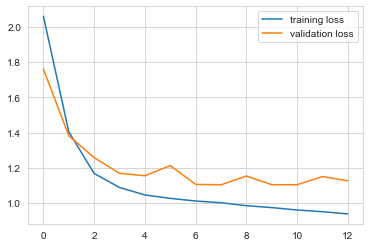

In [18]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

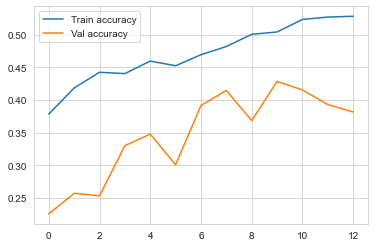

In [19]:
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')
plt.legend();

In [20]:
rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,293,394,27
actual 1,87,187,24
actual 2,94,179,17


In [21]:
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.24605263157894736

In [22]:
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.25

In [23]:
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.2463768115942029

In [24]:
rnn_proba = model.predict_proba(test_sequence)

Instructions for updating:
Please use `model.predict()` instead.


In [25]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.245156,0.528021,0.226823
1,0.285069,0.494741,0.220190
2,0.294475,0.395551,0.309974
3,0.245322,0.418519,0.336159
4,0.256973,0.417227,0.325800


In [26]:
results_compare = pd.DataFrame(X_test["day_of_wk"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [27]:
results_compare.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-21,2,2,1,0,0.245156,0.528021,0.226823
2015-10-22,3,2,1,0,0.285069,0.494741,0.220190
2015-10-23,4,0,1,0,0.294475,0.395551,0.309974
2015-10-25,6,0,1,0,0.245322,0.418519,0.336159
2015-10-26,0,2,1,0,0.256973,0.417227,0.325800


In [28]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-21,2,2,1,0,0.245156,0.528021,0.226823
2015-10-22,3,2,1,0,0.285069,0.494741,0.220190
2015-10-23,4,0,1,0,0.294475,0.395551,0.309974
2015-10-25,6,0,1,0,0.245322,0.418519,0.336159
2015-10-26,0,2,1,0,0.256973,0.417227,0.325800


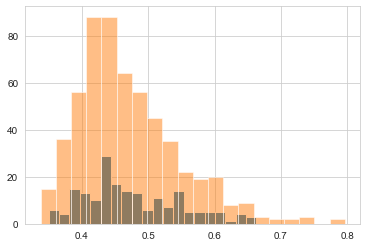

In [29]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [30]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-11-29,6,1,2,0,0.202780,0.362110,0.435110
2015-11-30,0,1,2,0,0.183965,0.360918,0.455117
2015-12-01,1,1,2,0,0.180956,0.369373,0.449671
2015-12-04,4,1,2,0,0.211870,0.269665,0.518465
2015-12-07,0,1,2,0,0.149215,0.373022,0.477764


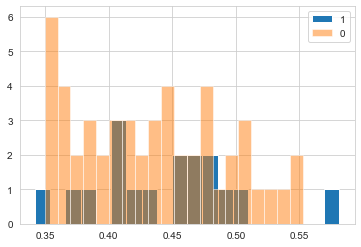

In [31]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

### un-randomized train set

In [32]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
series_length = 2

In [33]:
# Create training sequences
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=32)

In [34]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=32)

In [35]:
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [36]:
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [37]:
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Epoch 1/50
123/123 [==============================] - 2s 15ms/step - loss: 2.2002 - categorical_accuracy: 0.4107 - val_loss: 1.9678 - val_categorical_accuracy: 0.2398
Epoch 2/50
123/123 [==============================] - 1s 10ms/step - loss: 1.5928 - categorical_accuracy: 0.4283 - val_loss: 1.5425 - val_categorical_accuracy: 0.2498
Epoch 3/50
123/123 [==============================] - 1s 10ms/step - loss: 1.3211 - categorical_accuracy: 0.4270 - val_loss: 1.3596 - val_categorical_accuracy: 0.2813
Epoch 4/50
123/123 [==============================] - 1s 11ms/step - loss: 1.1781 - categorical_accuracy: 0.4598 - val_loss: 1.2930 - val_categorical_accuracy: 0.3028
Epoch 5/50
123/123 [==============================] - 1s 10ms/step - loss: 1.1103 - categorical_accuracy: 0.4767 - val_loss: 1.2849 - val_categorical_accuracy: 0.2790
Epoch 6/50
123/123 [==============================] - 1s 10ms/step - loss: 1.0596 - categorical_accuracy: 0.4834 - val_loss: 1.2445 - val_categorical_accuracy: 0.280

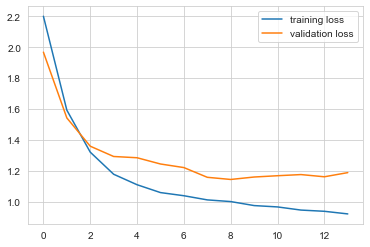

In [38]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

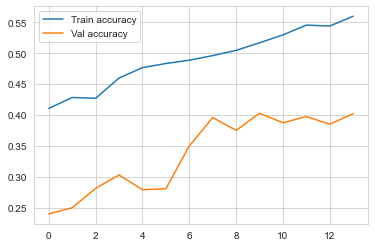

In [39]:
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')
plt.legend();

In [40]:
rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,332,308,74
actual 1,117,133,48
actual 2,113,118,58


In [41]:
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.23792486583184258

In [42]:
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.32222222222222224

In [43]:
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.2584573748308525

In [44]:
rnn_proba = model.predict_proba(test_sequence)

In [45]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.134622,0.502977,0.362401
1,0.183241,0.391182,0.425576
2,0.246576,0.301805,0.451618
3,0.274419,0.295643,0.429938
4,0.223205,0.269311,0.507484


In [46]:
results_compare = pd.DataFrame(X_test["day_of_wk"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [47]:
results_compare.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-22,3,2,1,0,0.134622,0.502977,0.362401
2015-10-23,4,0,2,0,0.183241,0.391182,0.425576
2015-10-25,6,0,2,0,0.246576,0.301805,0.451618
2015-10-26,0,2,2,1,0.274419,0.295643,0.429938
2015-10-27,1,2,2,1,0.223205,0.269311,0.507484


In [48]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-22,3,2,1,0,0.134622,0.502977,0.362401
2015-11-04,2,2,1,0,0.184050,0.508094,0.307856
2015-11-05,3,2,1,0,0.183520,0.538702,0.277778
2015-11-06,4,0,1,0,0.173038,0.536456,0.290507
2015-11-08,6,0,1,0,0.121784,0.587772,0.290444


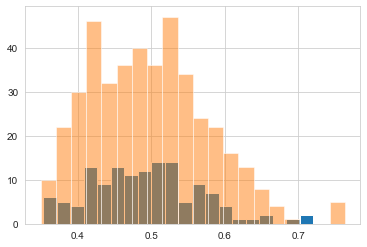

In [49]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [50]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-23,4,0,2,0,0.183241,0.391182,0.425576
2015-10-25,6,0,2,0,0.246576,0.301805,0.451618
2015-10-26,0,2,2,1,0.274419,0.295643,0.429938
2015-10-27,1,2,2,1,0.223205,0.269311,0.507484
2015-10-28,2,1,2,0,0.212263,0.321575,0.466162


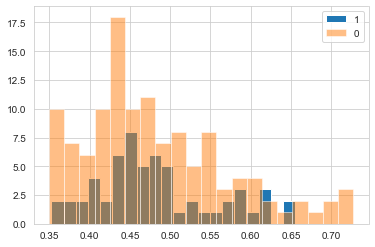

In [51]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

### un-randomized train set

In [52]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
series_length = 3

In [53]:
# Create training sequences
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=32)

In [54]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=32)

In [55]:
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [56]:
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [57]:
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Epoch 1/50
123/123 [==============================] - 3s 21ms/step - loss: 2.2563 - categorical_accuracy: 0.3810 - val_loss: 1.9928 - val_categorical_accuracy: 0.2731
Epoch 2/50
123/123 [==============================] - 2s 14ms/step - loss: 1.6527 - categorical_accuracy: 0.4461 - val_loss: 1.6527 - val_categorical_accuracy: 0.2446
Epoch 3/50
123/123 [==============================] - 2s 14ms/step - loss: 1.3618 - categorical_accuracy: 0.4576 - val_loss: 1.4518 - val_categorical_accuracy: 0.2946
Epoch 4/50
123/123 [==============================] - 2s 16ms/step - loss: 1.2121 - categorical_accuracy: 0.4612 - val_loss: 1.2955 - val_categorical_accuracy: 0.3585
Epoch 5/50
123/123 [==============================] - 2s 15ms/step - loss: 1.1178 - categorical_accuracy: 0.4825 - val_loss: 1.2183 - val_categorical_accuracy: 0.4085
Epoch 6/50
123/123 [==============================] - 2s 16ms/step - loss: 1.0750 - categorical_accuracy: 0.4855 - val_loss: 1.2251 - val_categorical_accuracy: 0.347

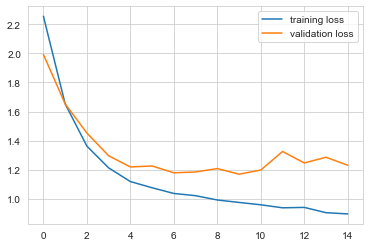

In [58]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

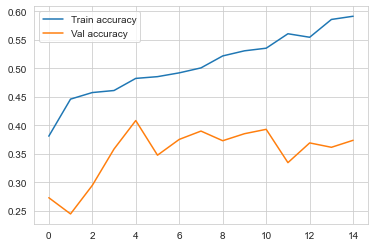

In [59]:
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')
plt.legend();

In [60]:
rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,284,372,58
actual 1,90,165,43
actual 2,91,160,37


In [61]:
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.23672883787661406

In [62]:
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.26811594202898553

In [63]:
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.24191616766467067

In [64]:
rnn_proba = model.predict_proba(test_sequence)

In [65]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.090683,0.650503,0.258814
1,0.181296,0.400272,0.418433
2,0.414334,0.292901,0.292764
3,0.290233,0.298886,0.410881
4,0.184978,0.411836,0.403185


In [66]:
results_compare = pd.DataFrame(X_test["day_of_wk"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [67]:
results_compare.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-23,4,0,1,0,0.090683,0.650503,0.258814
2015-10-25,6,0,2,0,0.181296,0.400272,0.418433
2015-10-26,0,2,0,0,0.414334,0.292901,0.292764
2015-10-27,1,2,2,1,0.290233,0.298886,0.410881
2015-10-28,2,1,1,1,0.184978,0.411836,0.403185


In [68]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-23,4,0,1,0,0.090683,0.650503,0.258814
2015-10-28,2,1,1,1,0.184978,0.411836,0.403185
2015-10-29,3,2,1,0,0.150937,0.503510,0.345553
2015-10-30,4,2,1,0,0.135459,0.452627,0.411913
2015-11-01,6,2,1,0,0.119679,0.477244,0.403078


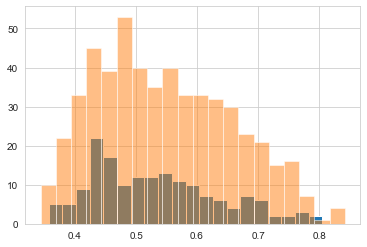

In [69]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [70]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-25,6,0,2,0,0.181296,0.400272,0.418433
2015-10-27,1,2,2,1,0.290233,0.298886,0.410881
2015-11-23,0,0,2,0,0.265544,0.291515,0.442941
2015-11-27,4,1,2,0,0.219993,0.306950,0.473057
2015-11-29,6,1,2,0,0.296305,0.204842,0.498852


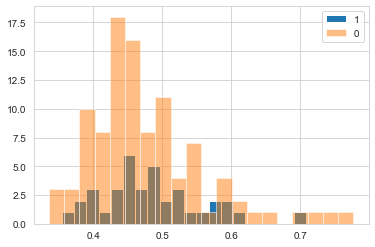

In [71]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

### un-randomized train set

In [72]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
series_length = 4

In [73]:
# Create training sequences
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=32)

In [74]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=32)

In [75]:
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [76]:
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [77]:
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Epoch 1/50
122/122 [==============================] - 3s 29ms/step - loss: 2.2828 - categorical_accuracy: 0.3883 - val_loss: 2.0335 - val_categorical_accuracy: 0.2964
Epoch 2/50
122/122 [==============================] - 3s 21ms/step - loss: 1.7202 - categorical_accuracy: 0.4188 - val_loss: 1.6142 - val_categorical_accuracy: 0.3957
Epoch 3/50
122/122 [==============================] - 3s 23ms/step - loss: 1.4182 - categorical_accuracy: 0.4472 - val_loss: 1.4413 - val_categorical_accuracy: 0.3318
Epoch 4/50
122/122 [==============================] - 3s 23ms/step - loss: 1.2489 - categorical_accuracy: 0.4667 - val_loss: 1.3522 - val_categorical_accuracy: 0.3164
Epoch 5/50
122/122 [==============================] - 2s 20ms/step - loss: 1.1544 - categorical_accuracy: 0.4764 - val_loss: 1.2961 - val_categorical_accuracy: 0.3587
Epoch 6/50
122/122 [==============================] - 2s 19ms/step - loss: 1.0884 - categorical_accuracy: 0.4987 - val_loss: 1.2039 - val_categorical_accuracy: 0.377

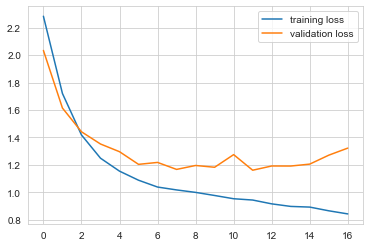

In [78]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

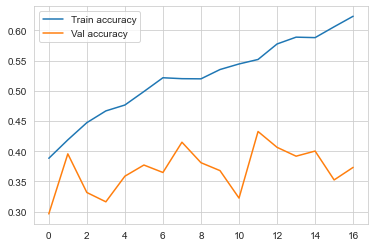

In [79]:
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')
plt.legend();

In [80]:
rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,280,390,43
actual 1,93,173,32
actual 2,98,158,32


In [81]:
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.23994452149791956

In [82]:
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.29906542056074764

In [83]:
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.24758454106280192

In [84]:
rnn_proba = model.predict_proba(test_sequence)

In [85]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.219531,0.420574,0.359896
1,0.217365,0.277287,0.505348
2,0.192704,0.236955,0.570341
3,0.157637,0.331020,0.511342
4,0.082264,0.473606,0.444130


In [86]:
results_compare = pd.DataFrame(X_test["day_of_wk"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [87]:
results_compare.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-25,6,0,1,0,0.219531,0.420574,0.359896
2015-10-26,0,2,2,1,0.217365,0.277287,0.505348
2015-10-27,1,2,2,1,0.192704,0.236955,0.570341
2015-10-28,2,1,2,0,0.157637,0.331020,0.511342
2015-10-29,3,2,1,0,0.082264,0.473606,0.444130


In [88]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-25,6,0,1,0,0.219531,0.420574,0.359896
2015-10-29,3,2,1,0,0.082264,0.473606,0.444130
2015-10-30,4,2,1,0,0.061192,0.488987,0.449822
2015-11-01,6,2,1,0,0.044910,0.504959,0.450131
2015-11-02,0,2,1,0,0.038932,0.525569,0.435499


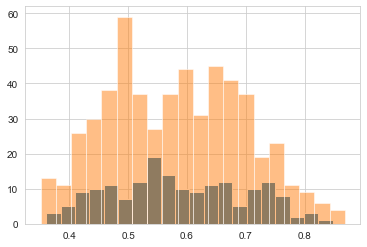

In [89]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [90]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-26,0,2,2,1,0.217365,0.277287,0.505348
2015-10-27,1,2,2,1,0.192704,0.236955,0.570341
2015-10-28,2,1,2,0,0.157637,0.331020,0.511342
2015-11-29,6,1,2,0,0.015511,0.309171,0.675318
2015-11-30,0,1,2,0,0.011033,0.416358,0.572610


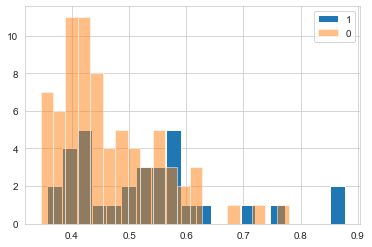

In [91]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

### un-randomized train set

In [92]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
series_length = 5

In [93]:
# Create training sequences
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=32)

In [94]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=32)

In [95]:
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [96]:
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [97]:
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Epoch 1/50
122/122 [==============================] - 3s 27ms/step - loss: 2.3075 - categorical_accuracy: 0.3815 - val_loss: 2.1442 - val_categorical_accuracy: 0.2589
Epoch 2/50
122/122 [==============================] - 3s 22ms/step - loss: 1.7656 - categorical_accuracy: 0.4199 - val_loss: 1.7018 - val_categorical_accuracy: 0.3582
Epoch 3/50
122/122 [==============================] - 3s 22ms/step - loss: 1.4569 - categorical_accuracy: 0.4479 - val_loss: 1.4332 - val_categorical_accuracy: 0.4337
Epoch 4/50
122/122 [==============================] - 3s 22ms/step - loss: 1.2782 - categorical_accuracy: 0.4771 - val_loss: 1.3284 - val_categorical_accuracy: 0.4114
Epoch 5/50
122/122 [==============================] - 3s 21ms/step - loss: 1.1713 - categorical_accuracy: 0.4871 - val_loss: 1.2476 - val_categorical_accuracy: 0.4214
Epoch 6/50
122/122 [==============================] - 3s 22ms/step - loss: 1.1075 - categorical_accuracy: 0.4858 - val_loss: 1.2718 - val_categorical_accuracy: 0.345

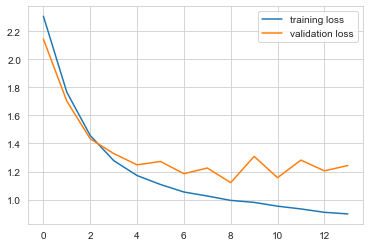

In [98]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

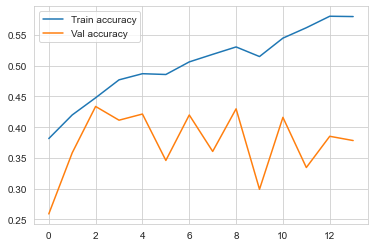

In [99]:
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')
plt.legend();

In [100]:
rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,277,310,125
actual 1,85,146,67
actual 2,102,118,68


In [101]:
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.25435540069686413

In [102]:
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.26153846153846155

In [103]:
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.2565947242206235

In [104]:
rnn_proba = model.predict_proba(test_sequence)

In [105]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.147063,0.406104,0.446834
1,0.223552,0.252174,0.524274
2,0.261905,0.201488,0.536607
3,0.191689,0.239295,0.569016
4,0.139131,0.241792,0.619077


In [106]:
results_compare = pd.DataFrame(X_test["day_of_wk"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [107]:
results_compare.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-26,0,2,2,1,0.147063,0.406104,0.446834
2015-10-27,1,2,2,1,0.223552,0.252174,0.524274
2015-10-28,2,1,2,0,0.261905,0.201488,0.536607
2015-10-29,3,2,2,1,0.191689,0.239295,0.569016
2015-10-30,4,2,2,1,0.139131,0.241792,0.619077


In [108]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-11-05,3,2,1,0,0.283963,0.367270,0.348767
2015-11-06,4,0,1,0,0.301122,0.361958,0.336921
2015-11-08,6,0,1,0,0.182324,0.488089,0.329587
2015-11-09,0,0,1,0,0.114503,0.537059,0.348438
2015-11-10,1,2,1,0,0.094551,0.476812,0.428637


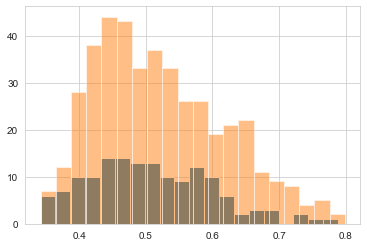

In [109]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [110]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-26,0,2,2,1,0.147063,0.406104,0.446834
2015-10-27,1,2,2,1,0.223552,0.252174,0.524274
2015-10-28,2,1,2,0,0.261905,0.201488,0.536607
2015-10-29,3,2,2,1,0.191689,0.239295,0.569016
2015-10-30,4,2,2,1,0.139131,0.241792,0.619077


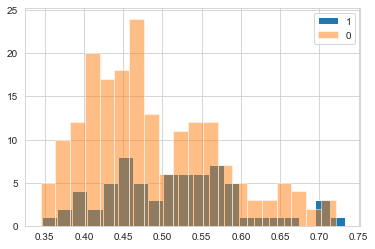

In [111]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

### un-randomized train set

In [112]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
series_length = 6

In [113]:
# Create training sequences
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=32)

In [114]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=32)

In [115]:
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [116]:
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [117]:
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Epoch 1/50
122/122 [==============================] - 4s 31ms/step - loss: 2.2980 - categorical_accuracy: 0.4047 - val_loss: 2.1449 - val_categorical_accuracy: 0.3146
Epoch 2/50
122/122 [==============================] - 3s 25ms/step - loss: 1.7984 - categorical_accuracy: 0.4088 - val_loss: 1.7209 - val_categorical_accuracy: 0.3647
Epoch 3/50
122/122 [==============================] - 3s 23ms/step - loss: 1.5028 - categorical_accuracy: 0.4585 - val_loss: 1.5123 - val_categorical_accuracy: 0.3901
Epoch 4/50
122/122 [==============================] - 3s 27ms/step - loss: 1.3169 - categorical_accuracy: 0.4785 - val_loss: 1.3377 - val_categorical_accuracy: 0.4487
Epoch 5/50
122/122 [==============================] - 4s 29ms/step - loss: 1.2160 - categorical_accuracy: 0.4928 - val_loss: 1.3841 - val_categorical_accuracy: 0.3292
Epoch 6/50
122/122 [==============================] - 3s 24ms/step - loss: 1.1286 - categorical_accuracy: 0.5072 - val_loss: 1.2207 - val_categorical_accuracy: 0.447

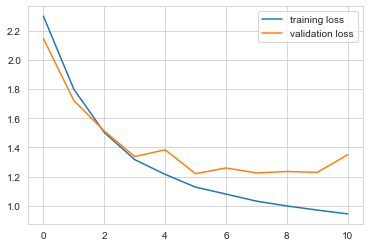

In [118]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

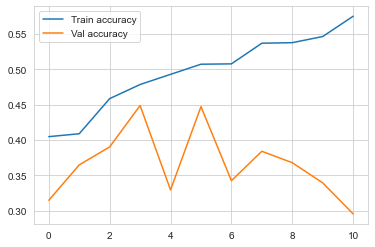

In [119]:
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')
plt.legend();

In [120]:
rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,125,509,78
actual 1,43,193,62
actual 2,42,180,65


In [121]:
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.21882086167800455

In [122]:
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.3170731707317073

In [123]:
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.23735050597976082

In [124]:
rnn_proba = model.predict_proba(test_sequence)

In [125]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.284621,0.352443,0.362936
1,0.301050,0.352652,0.346297
2,0.248096,0.444838,0.307066
3,0.159591,0.505072,0.335337
4,0.103432,0.561917,0.334651


In [126]:
results_compare = pd.DataFrame(X_test["day_of_wk"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [127]:
results_compare.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-27,1,2,2,1,0.284621,0.352443,0.362936
2015-10-28,2,1,1,1,0.301050,0.352652,0.346297
2015-10-29,3,2,1,0,0.248096,0.444838,0.307066
2015-10-30,4,2,1,0,0.159591,0.505072,0.335337
2015-11-01,6,2,1,0,0.103432,0.561917,0.334651


In [128]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-28,2,1,1,1,0.301050,0.352652,0.346297
2015-10-29,3,2,1,0,0.248096,0.444838,0.307066
2015-10-30,4,2,1,0,0.159591,0.505072,0.335337
2015-11-01,6,2,1,0,0.103432,0.561917,0.334651
2015-11-02,0,2,1,0,0.094871,0.557546,0.347583


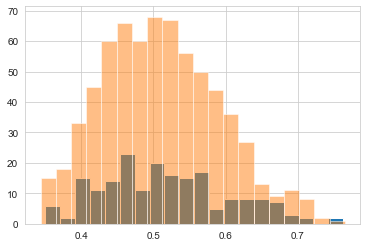

In [129]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [130]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-27,1,2,2,1,0.284621,0.352443,0.362936
2015-11-20,4,0,2,0,0.060997,0.414244,0.524759
2015-11-22,6,0,2,0,0.060775,0.442943,0.496282
2015-11-23,0,0,2,0,0.087849,0.432339,0.479812
2015-11-24,1,0,2,0,0.095358,0.409313,0.495330


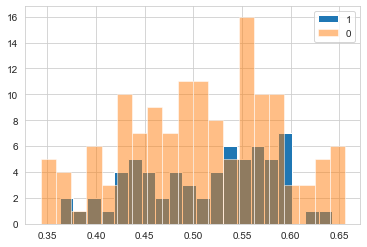

In [131]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

### un-randomized train set

In [132]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
series_length = 7

In [133]:
# Create training sequences
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=32)

In [134]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=32)

In [135]:
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [136]:
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [137]:
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Epoch 1/50
122/122 [==============================] - 4s 33ms/step - loss: 2.3368 - categorical_accuracy: 0.3794 - val_loss: 2.1630 - val_categorical_accuracy: 0.3040
Epoch 2/50
122/122 [==============================] - 3s 26ms/step - loss: 1.8390 - categorical_accuracy: 0.4207 - val_loss: 1.8554 - val_categorical_accuracy: 0.2963
Epoch 3/50
122/122 [==============================] - 3s 27ms/step - loss: 1.5440 - categorical_accuracy: 0.4642 - val_loss: 1.5868 - val_categorical_accuracy: 0.3380
Epoch 4/50
122/122 [==============================] - 3s 27ms/step - loss: 1.3687 - categorical_accuracy: 0.4748 - val_loss: 1.4284 - val_categorical_accuracy: 0.3789
Epoch 5/50
122/122 [==============================] - 3s 28ms/step - loss: 1.2392 - categorical_accuracy: 0.4960 - val_loss: 1.3295 - val_categorical_accuracy: 0.3688
Epoch 6/50
122/122 [==============================] - 3s 27ms/step - loss: 1.1498 - categorical_accuracy: 0.4927 - val_loss: 1.3093 - val_categorical_accuracy: 0.393

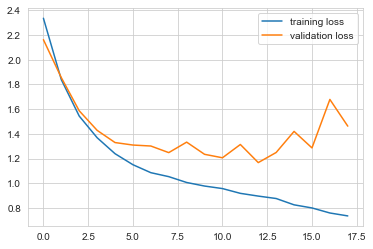

In [138]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

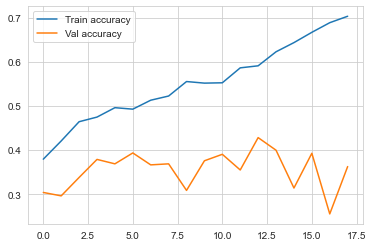

In [139]:
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')
plt.legend();

In [140]:
rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,268,409,35
actual 1,88,181,29
actual 2,85,180,21


In [141]:
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.23506493506493506

In [142]:
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.24705882352941178

In [143]:
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.23625730994152047

In [144]:
rnn_proba = model.predict_proba(test_sequence)

In [145]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.513564,0.288090,0.198346
1,0.485327,0.341776,0.172897
2,0.455350,0.367467,0.177183
3,0.202906,0.513993,0.283101
4,0.078999,0.678146,0.242855


In [146]:
results_compare = pd.DataFrame(X_test["day_of_wk"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [147]:
results_compare.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-28,2,1,0,0,0.513564,0.288090,0.198346
2015-10-29,3,2,0,0,0.485327,0.341776,0.172897
2015-10-30,4,2,0,0,0.455350,0.367467,0.177183
2015-11-01,6,2,1,0,0.202906,0.513993,0.283101
2015-11-02,0,2,1,0,0.078999,0.678146,0.242855


In [148]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-11-01,6,2,1,0,0.202906,0.513993,0.283101
2015-11-02,0,2,1,0,0.078999,0.678146,0.242855
2015-11-03,1,2,1,0,0.054521,0.718038,0.227440
2015-11-04,2,2,1,0,0.053991,0.631783,0.314226
2015-11-05,3,2,1,0,0.045684,0.567498,0.386818


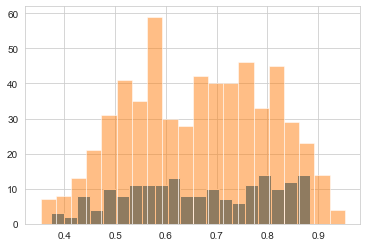

In [149]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [150]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-12-04,4,1,2,0,0.027153,0.146568,0.826279
2015-12-06,6,1,2,0,0.039514,0.284170,0.676316
2015-12-07,0,1,2,0,0.065458,0.289641,0.644901
2015-12-09,2,2,2,1,0.214620,0.380292,0.405089
2016-03-14,0,1,2,0,0.062782,0.447611,0.489607


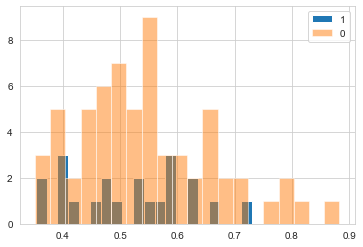

In [151]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()